In [1]:
#Sci-kit
from sklearn.ensemble import RandomForestRegressor

#Torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetRegressor

#xg-boost
import xgboost as xgb

from visualization.visualize import *
from data.data_loader import *
from data.data_processing import processData, getDataProcessor, trainValTestSplit, transformTimestamp
from models.training import trainModels
from models.model import Model
from models.neuralnetwork.architecture import ThroughputPredictor

/Users/eriklinde/Einride/msc-degree-project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
dirCsv = "../data/raw/5G-production-dataset/Download/Driving/"
dirParquet = "../data/intermediate/"
emptyData = "-"
saveDataParquet(dirCsv,dirParquet,emptyData="-")

In [3]:
df = loadDataParquet(dirParquet)

In [4]:
### DATA PREPARATION ###
dependentCol = "UL_bitrate"

selectedFloatCols = ["Longitude", "Latitude", "Speed", "RSRP","RSRQ","SNR", "Time_of_day"]
selectedCatCols = ["CellID"]

df = transformTimestamp(df, "Timestamp", timeOfDayCol="Time_of_day")
processor = getDataProcessor(selectedFloatCols, selectedCatCols, applyScaler=True)
dataX, dataY = processData(df, selectedFloatCols, selectedCatCols, dependentCol, processor)
dataX.size


/Users/eriklinde/Einride/msc-degree-project/.venv/lib/python3.9/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Users/eriklinde/Einride/msc-degree-project/.venv/lib/python3.9/site-packages/category_encoders/ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
/Users/eriklinde/Einride/msc-degree-project/.venv/lib/python3.9/site-packages/category_encoders/ordina

253099

In [5]:
### DIVIDE INTO TRAINING, VALIDATION AND TEST ###
trainRatio = 0.75
validatioRatio = 0.15

xTrain, xVal, xTest, yTrain, yVal, yTest = trainValTestSplit(dataX, dataY, trainRatio, validatioRatio)

In [6]:
### SELECT MODELS ###
rf = RandomForestRegressor(random_state=42)

paramGridRf = {
    # 'n_estimators': [100, 300, 500],        # Number of trees in the forest
    # 'max_depth': [None, 10, 20, 30],        # Maximum depth of the tree
    # 'min_samples_split': [2, 5, 10],        # Minimum number of samples required to split an internal node
    # 'min_samples_leaf': [1, 2, 4],          # Minimum number of samples required to be at a leaf node
    # 'max_features': ['sqrt', 'log2']        # Number of features to consider when looking for the best split
    'n_estimators': [300],
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

xGradBoost = xgb.XGBRegressor(random_state=42)

# Define the parameter grid for XGBoost
paramGridXgb = {
    # 'n_estimators': [100, 200, 300],
    # 'learning_rate': [0.01, 0.1, 0.2],
    # 'max_depth': [3, 6, 9],
    # 'subsample': [0.8, 1.0],
    # 'colsample_bytree': [0.8, 1.0],
    # 'gamma': [0, 0.1, 0.2],
    # 'reg_alpha': [0, 0.01, 0.1],
    # 'reg_lambda': [1, 1.5, 2]

    'n_estimators': [200],
    'learning_rate': [0.05],
    'max_depth': [5],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0.1],
    'reg_alpha': [0.01],
    'reg_lambda': [1.5]
}

net = NeuralNetRegressor(
    ThroughputPredictor,
    module__input_size=dataX.shape[1],  # Pass the input size to the module
    optimizer=optim.Adam,               # Optimizer
    criterion=nn.MSELoss,               # Loss function
    verbose=0,                          # Silence verbose output
    train_split=None                    # Disable internal train/val split, external CV used
)

paramGridNet = {
    # 'lr': [0.01,0.001],
    # 'max_epochs': [100,200],
    # 'optimizer__weight_decay': [0.01,0.001],
    # 'batch_size': [32,64,128],
    'lr': [0.01],
    'max_epochs': [100],
    'optimizer__weight_decay': [0.01],
    'batch_size': [128]
}

models = [Model(rf, "Random Forest", paramGridRf), Model(xGradBoost, "XGBoost", paramGridXgb), Model(net, "Neural Network", paramGridNet)]


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters for Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training MSE: 2640.76
Training R^2: 0.73
Validation MSE: 6307.63
Validation R^2: 0.37
Test MSE: 6159.54
Test R^2: 0.41

Best Parameters for XGBoost: None
Training MSE: 6851.37
Training R^2: 0.29
Validation MSE: 7970.20
Validation R^2: 0.21
Test MSE: 8154.10
Test R^2: 0.22

Best Parameters for Neural Network: None
Training MSE: 7452.28
Training R^2: 0.23
Validation MSE: 8414.42
Validation R^2: 0.16
Test MSE: 9052.90
Test R^2: 0.14



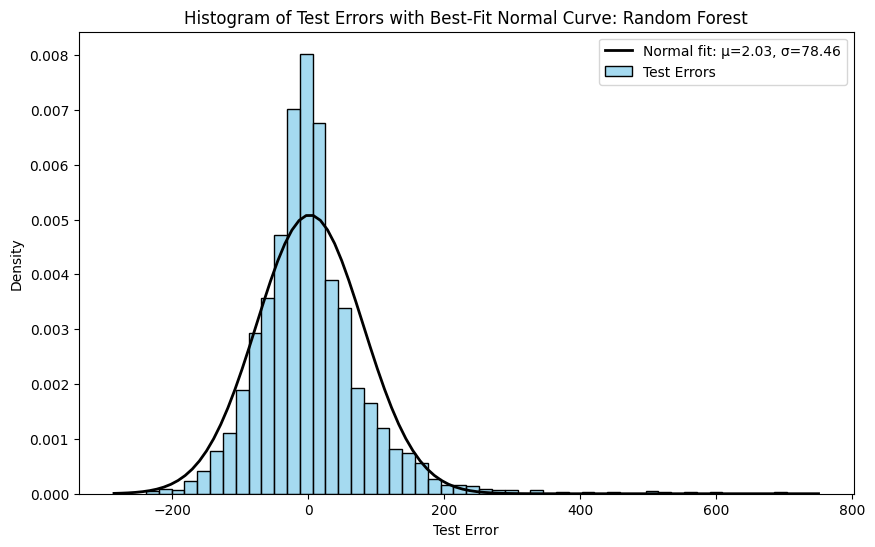

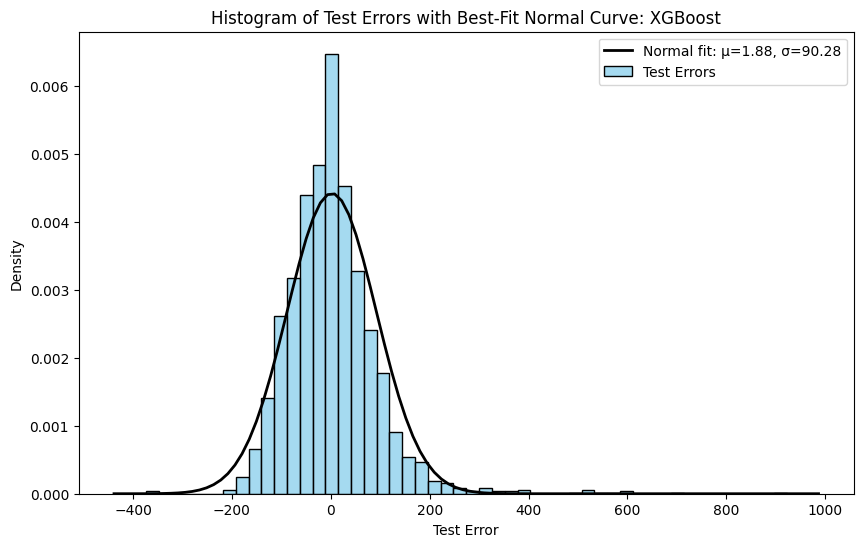

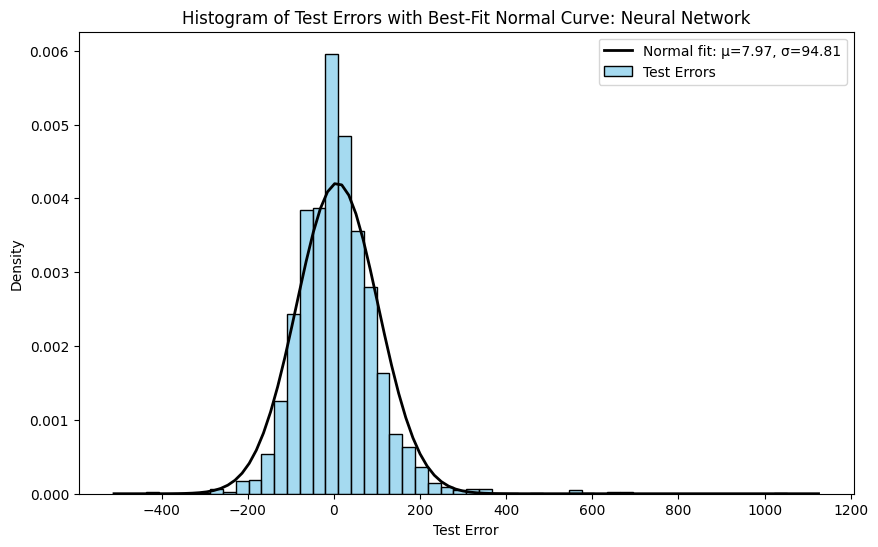

In [7]:
### TRAINING AND EVALUATION ###
errors = trainModels(models, xTrain, yTrain, xVal, yVal, xTest, yTest)
plotModelsErrors(errors,models)